## Importing the Libraries and Data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

!pip install fuzzywuzzy
!pip install python-Levenshtein
from fuzzywuzzy import fuzz

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, tree, ensemble

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/CapstoneProject/train.csv")

## Exploratory Data Analysis

In [20]:
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [21]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [23]:
#question1 has 1 null value 
#question2 has 2 null values
#Let's locate which question1 has a null value
df[df.question1.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [24]:
#The Null question1 has an qid1 = 493340. 
#Let's check if there is an instance of qid = 493340 is present anywhere in the dataset with a valid question attached to it.
df[(df.qid1 == 493340) | (df.qid2 == 493340)]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [0]:
#We cannot fill this null question1 with the correct question. It is better to delete the record.

In [26]:
#Let's check how many records are there where question2 is null
df[df.question2.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [27]:
#The 2 instances of Null question2 have ids 174364. 
#Let's check if there is an instance of qid = 174364 is present anywhere in the dataset with a valid question attached to it.
df[(df.qid1 == 174364) | (df.qid2 == 174364)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [0]:
#We cannot fill this null question1 with the correct question. It is better to delete the record.

In [0]:
#Deleting records with null in qid1 or qid2
df = df.dropna(subset=['question1','question2'])

In [30]:
#Verifying the deletes
df[(df.question1.isnull()) | (df.question2.isnull())]

,id,qid1,qid2,question1,question2,is_duplicate


In [31]:
#Let's check if there are any records where question1 == question2
df[df.question1 == df.question2]

,id,qid1,qid2,question1,question2,is_duplicate


In [32]:
#Let's check if a qid1, qid2 pair is repeated more than once
pair_count = df.groupby(['qid1','qid2']).size()
pair_count[pair_count > 1]

Series([], dtype: int64)

In [33]:
#The above code will not capture the scenario if qid1 and qid2 are interchanged. 
#Let's see if there cases such as qid1=N1/qid2=N2 and qid1=N2/qid2=N1.
list_of_qids_1_2 = (df['qid1'].astype(str) + '-' + df['qid2'].astype(str)).tolist() 
list_of_qids_2_1 = (df['qid2'].astype(str) + '-' + df['qid1'].astype(str)).tolist()
combined_list = pd.Series(list_of_qids_1_2 + list_of_qids_2_1)
result = combined_list.duplicated()
result[result == True]

Series([], dtype: bool)

In [34]:
#Let's check how many unique instances of qid1 are there.
len(df.qid1.unique())

290652

In [35]:
#Let's check how many unique instances of qid2 are there.
len(df.qid2.unique())

299362

In [0]:
#Based on the above queries, a question might be repeated in more than one pair.

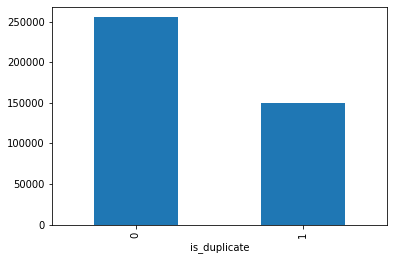

In [37]:
#Graph of duplicates vs non-duplicates
df.groupby("is_duplicate")['id'].count().plot.bar()

In [38]:
#Average number of words per question
print('Mean question1 : ', df['question1'].str.split().apply(len).mean(), ' words')
print('Median question1 : ', df['question1'].str.split().apply(len).median(), ' words')
print('Mean question1 : ', df['question1'].str.split().apply(len).mean(), ' words')
print('Median question1 : ', df['question1'].str.split().apply(len).median(), ' words')

Mean question1 :  10.942256367382576  words
Median question1 :  10.0  words
Mean question1 :  10.942256367382576  words
Median question1 :  10.0  words


In [39]:
print('Not Duplicate Question Pairs (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nDuplicate Question Pairs (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Not Duplicate Question Pairs (is_duplicate = 0):
   63.08%

Duplicate Question Pairs (is_duplicate = 1):
   36.92%


In [0]:
df = df.sample(n = 10000) 

## Processing Text Data

In [0]:
#Deleting records with null in qid1 or qid2
df = df.dropna(subset=['question1','question2'])

In [32]:
#Convert question1 and question2 to lower case
df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
339642,339642,467301,467302,why is donald trump so awesome?,why is donald trump awesome?,1
159952,159952,249593,249594,should i try being pretty?,how is neurolysis done?,0
248457,248457,361890,361891,how do i ask girls that i want to lick their p...,would you urinate in a girls mouth if she aske...,0
242808,242808,355097,355098,heaven: who is the strongest angel?,do dogs go to heaven?,0
207606,207606,311341,311342,what does an essay score of 6/6/6 on the new s...,how good is ielts overall score of 6.0?,0


In [33]:
#Remove punctuation
df['question1'] = df['question1'].str.replace(r'[^\w\s]+', '')
df['question2'] = df['question2'].str.replace(r'[^\w\s]+', '')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
339642,339642,467301,467302,why is donald trump so awesome,why is donald trump awesome,1
159952,159952,249593,249594,should i try being pretty,how is neurolysis done,0
248457,248457,361890,361891,how do i ask girls that i want to lick their p...,would you urinate in a girls mouth if she aske...,0
242808,242808,355097,355098,heaven who is the strongest angel,do dogs go to heaven,0
207606,207606,311341,311342,what does an essay score of 666 on the new sat...,how good is ielts overall score of 60,0


In [0]:
#Word Replacements
def word_replace(x):
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                            .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                            .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                            .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                            .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                            .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                            .replace("€", " euro ").replace("'ll", " will")
  return x

df["question1"] = df["question1"].fillna("").apply(word_replace)
df["question2"] = df["question2"].fillna("").apply(word_replace)

In [35]:
#Lemmatization
df['question1'] = df['question1'].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]))
df['question2'] = df['question2'].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
339642,339642,467301,467302,why is donald trump so awesome,why is donald trump awesome,1
159952,159952,249593,249594,should i try being pretty,how is neurolysis done,0
248457,248457,361890,361891,how do i ask girl that i want to lick their pu...,would you urinate in a girl mouth if she asked...,0
242808,242808,355097,355098,heaven who is the strongest angel,do dog go to heaven,0
207606,207606,311341,311342,what doe an essay score of 666 on the new sat ...,how good is ielts overall score of 60,0


## Feature Extraction

In [0]:
#Words difference q1, q2
df['words_diff_q1_q2'] = abs(df['question1'].apply(lambda row: len(row.split(" "))) - df['question2'].apply(lambda row: len(row.split(" "))))

In [0]:
#Number of common unique words in Question 1 and Question 2
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
    
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

In [0]:
#Total num of words in Question 1 + Total num of words in Question 2
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    
df['word_Total'] = df.apply(normalized_word_Total, axis=1)    

In [0]:
#word_share = (word_common)/(word_Total)
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [40]:
#Distance computations

q1_q1_vectors = {}

def get_q1_q1_vectors(row):

      if row['id'] not in q1_q1_vectors:
          
          tfidf_matrix_list =[]

          documents = []
          documents.append(row['question1'].replace("\n", " "))
          documents.append(row['question2'].replace("\n", " "))
          tfidf_vectorizer = TfidfVectorizer(max_features = 200)
          tfidf_vectorizer.fit(documents) 

          documents = []
          documents.append(row['question1'].replace("\n", " "))
          tfidf_matrix_q1 = tfidf_vectorizer.transform(documents)  
          tfidf_matrix_list.append(tfidf_matrix_q1)

          documents = []
          documents.append(row['question2'].replace("\n", " "))
          tfidf_matrix_q2 = tfidf_vectorizer.transform(documents) 
          tfidf_matrix_list.append(tfidf_matrix_q2)

          q1_q1_vectors[row['id']] = tfidf_matrix_list

      return q1_q1_vectors[row['id']][0], q1_q1_vectors[row['id']][1]

def get_cosine_distance(row):
  q1_q1_vectors = get_q1_q1_vectors(row)
  return cosine(q1_q1_vectors[0].toarray(), q1_q1_vectors[1].toarray())

def get_cityblock_distance(row):
  q1_q1_vectors = get_q1_q1_vectors(row)
  return cityblock(q1_q1_vectors[0].toarray(), q1_q1_vectors[1].toarray())

def get_jaccard_distance(row):
  q1_q1_vectors = get_q1_q1_vectors(row)
  return jaccard(q1_q1_vectors[0].toarray(), q1_q1_vectors[1].toarray(),)

def get_canberra_distance(row):
  q1_q1_vectors = get_q1_q1_vectors(row)
  return canberra(q1_q1_vectors[0].toarray(), q1_q1_vectors[1].toarray())

def get_euclidean_distance(row):
  q1_q1_vectors = get_q1_q1_vectors(row)
  return euclidean(q1_q1_vectors[0].toarray(), q1_q1_vectors[1].toarray())

def get_minkowski_distance(row):
  q1_q1_vectors = get_q1_q1_vectors(row)
  return minkowski(q1_q1_vectors[0].toarray(), q1_q1_vectors[1].toarray())

def get_braycurtis_distance(row):
  q1_q1_vectors = get_q1_q1_vectors(row)
  return braycurtis(q1_q1_vectors[0].toarray(), q1_q1_vectors[1].toarray())  

df['cosine_distance'] = df.apply(get_cosine_distance, axis=1)  
df['cityblock_distance'] = df.apply(get_cityblock_distance, axis=1)
df['jaccard_distance'] = df.apply(get_jaccard_distance, axis=1)
df['canberra_distance'] = df.apply(get_canberra_distance, axis=1)
df['euclidean_distance'] = df.apply(get_euclidean_distance, axis=1)
df['minkowski_distance'] = df.apply(get_minkowski_distance, axis=1)
df['braycurtis_distance'] = df.apply(get_braycurtis_distance, axis=1)


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [41]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
339642,339642,467301,467302,why is donald trump so awesome,why is donald trump awesome,1,1,5.0,11.0,0.454545,0.153353,0.875061,1.0,1.415219,0.553810,0.553810,0.187726
159952,159952,249593,249594,should i try being pretty,how is neurolysis done,0,1,0.0,9.0,0.000000,1.000000,4.000000,1.0,8.000000,1.414214,1.414214,1.000000
248457,248457,361890,361891,how do i ask girl that i want to lick their pu...,would you urinate in a girl mouth if she asked...,0,10,1.0,30.0,0.033333,0.970474,6.801042,1.0,26.156464,1.393179,1.393179,0.958629
242808,242808,355097,355098,heaven who is the strongest angel,do dog go to heaven,0,1,1.0,11.0,0.090909,0.898369,4.047069,1.0,9.050063,1.340425,1.340425,0.869683
207606,207606,311341,311342,what doe an essay score of 666 on the new sat ...,how good is ielts overall score of 60,0,4,2.0,20.0,0.100000,0.884784,5.387728,1.0,16.224716,1.330251,1.330251,0.862678


In [0]:
# FuzzyWuzzy is a library of Python which is used for string matching. 
# Fuzzy string matching is the process of finding strings that match a given pattern. 
# Basically it uses Levenshtein Distance to calculate the differences between sequences.

df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [43]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
339642,339642,467301,467302,why is donald trump so awesome,why is donald trump awesome,1,1,5.0,11.0,0.454545,0.153353,0.875061,1.0,1.415219,0.553810,0.553810,0.187726,95,95,89,100,89,100,95
159952,159952,249593,249594,should i try being pretty,how is neurolysis done,0,1,0.0,9.0,0.000000,1.000000,4.000000,1.0,8.000000,1.414214,1.414214,1.000000,38,38,32,38,38,30,30
248457,248457,361890,361891,how do i ask girl that i want to lick their pu...,would you urinate in a girl mouth if she asked...,0,10,1.0,30.0,0.033333,0.970474,6.801042,1.0,26.156464,1.393179,1.393179,0.958629,30,86,39,100,44,42,38
242808,242808,355097,355098,heaven who is the strongest angel,do dog go to heaven,0,1,1.0,11.0,0.090909,0.898369,4.047069,1.0,9.050063,1.340425,1.340425,0.869683,23,86,32,100,58,50,42
207606,207606,311341,311342,what doe an essay score of 666 on the new sat ...,how good is ielts overall score of 60,0,4,2.0,20.0,0.100000,0.884784,5.387728,1.0,16.224716,1.330251,1.330251,0.862678,30,42,49,100,43,39,44


## Model Building and Predicting





In [44]:
X = df[['words_diff_q1_q2', 'word_Common',	'word_Total', 'word_share', 'cosine_distance','cityblock_distance',	'jaccard_distance','canberra_distance',	'euclidean_distance','minkowski_distance','braycurtis_distance', 'fuzz_qratio',	'fuzz_WRatio',	'fuzz_partial_ratio',	'fuzz_partial_token_set_ratio',	'fuzz_partial_token_sort_ratio',	'fuzz_token_set_ratio',	'fuzz_token_sort_ratio']]
y = df['is_duplicate']
X.head()

,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
339642,1,5.0,11.0,0.454545,0.153353,0.875061,1.0,1.415219,0.553810,0.553810,0.187726,95,95,89,100,89,100,95
159952,1,0.0,9.0,0.000000,1.000000,4.000000,1.0,8.000000,1.414214,1.414214,1.000000,38,38,32,38,38,30,30
248457,10,1.0,30.0,0.033333,0.970474,6.801042,1.0,26.156464,1.393179,1.393179,0.958629,30,86,39,100,44,42,38
242808,1,1.0,11.0,0.090909,0.898369,4.047069,1.0,9.050063,1.340425,1.340425,0.869683,23,86,32,100,58,50,42
207606,4,2.0,20.0,0.100000,0.884784,5.387728,1.0,16.224716,1.330251,1.330251,0.862678,30,42,49,100,43,39,44


In [0]:
#Splitting the dataset into the Training set and the Test set
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 99)

X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [0]:
#Defining the generic training pipeline
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):

  #fit the training dataset on the classifier
  classifier.fit(feature_vector_train, label)

  #predict the labels on validation dataset
  predictions = classifier.predict(feature_vector_valid)

  return metrics.accuracy_score(y_test, predictions), metrics.classification_report(y_test,predictions),metrics.confusion_matrix(y_test,predictions)

## **Logistic Regression**

In [47]:
training_results_LR = train_model(linear_model.LogisticRegression(random_state = 99, max_iter=200), X_train, y_train, X_test)

print(f'Accuracy Score : {training_results_LR[0]}')
print(f'Classification Report : \n{training_results_LR[1]}')
print(f'Confusion Matrix : \n{training_results_LR[2]}')

Accuracy Score : 0.6848
Classification Report : 
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1561
           1       0.59      0.53      0.56       939

    accuracy                           0.68      2500
   macro avg       0.66      0.65      0.66      2500
weighted avg       0.68      0.68      0.68      2500

Confusion Matrix : 
[[1216  345]
 [ 443  496]]


## **Naive Bayes**

In [55]:
training_results_NB = train_model(naive_bayes.BernoulliNB(), X_train, y_train, X_test)

print(f'Accuracy Score : {training_results_NB[0]}')
print(f'Classification Report : \n{training_results_NB[1]}')
print(f'Confusion Matrix : \n{training_results_NB[2]}')

Accuracy Score : 0.6556
Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      1561
           1       0.53      0.66      0.59       939

    accuracy                           0.66      2500
   macro avg       0.65      0.66      0.65      2500
weighted avg       0.68      0.66      0.66      2500

Confusion Matrix : 
[[1017  544]
 [ 317  622]]


## **SVM Classification**

In [49]:
training_results_SVM = train_model(svm.SVC(kernel='linear',random_state = 99), X_train, y_train, X_test)

print(f'Accuracy Score : {training_results_SVM[0]}')
print(f'Classification Report : \n{training_results_SVM[1]}')
print(f'Confusion Matrix : \n{training_results_SVM[2]}')

Accuracy Score : 0.6884
Classification Report : 
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1561
           1       0.60      0.53      0.56       939

    accuracy                           0.69      2500
   macro avg       0.67      0.66      0.66      2500
weighted avg       0.68      0.69      0.68      2500

Confusion Matrix : 
[[1226  335]
 [ 444  495]]


## **Decision-Tree Classification**

In [50]:
training_results_DTree = train_model(tree.DecisionTreeClassifier(random_state = 99), X_train, y_train, X_test)

print(f'Accuracy Score : {training_results_DTree[0]}')
print(f'Classification Report : \n{training_results_DTree[1]}')
print(f'Confusion Matrix : \n{training_results_DTree[2]}')

Accuracy Score : 0.6468
Classification Report : 
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1561
           1       0.53      0.54      0.53       939

    accuracy                           0.65      2500
   macro avg       0.62      0.62      0.62      2500
weighted avg       0.65      0.65      0.65      2500

Confusion Matrix : 
[[1114  447]
 [ 436  503]]


## **Random-Forest Classification**

In [51]:
training_results_RandF = train_model(ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state = 99), X_train, y_train, X_test)

print(f'Accuracy Score : {training_results_RandF[0]}')
print(f'Classification Report : \n{training_results_RandF[1]}')
print(f'Confusion Matrix : \n{training_results_RandF[2]}')

Accuracy Score : 0.7056
Classification Report : 
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1561
           1       0.61      0.61      0.61       939

    accuracy                           0.71      2500
   macro avg       0.69      0.69      0.69      2500
weighted avg       0.71      0.71      0.71      2500

Confusion Matrix : 
[[1190  371]
 [ 365  574]]
